In [3]:
# NOTE - Shutdown vscode and restart it to make sure the kernel is updated

# Imports
import json
import logging
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Setup logging with INFO level
logging.basicConfig(level=logging.INFO)

# Customizable settings
MIN_NUM_VOTES = 1000
DAILY_WATCH_TIME = 1 # hours
CURRENT_AGE = 30 # years
DEATH_AGE = 80 # years
TITLE_TYPES = ['movie', 'tvSeries']

# Load data from TSV file
TITLES = 'title.basics.tsv'
RATINGS = 'title.ratings.tsv'

In [6]:
# Download fresh data from IMDb
DOWNLOAD = True

# Download IMDb data on a Mac
if DOWNLOAD:
    logging.info('Downloading IMDb data')
    os.system(f"curl -O https://datasets.imdbws.com/{TITLES}.gz")
    os.system(f"curl -O https://datasets.imdbws.com/{RATINGS}.gz")
    # Unzip the files overwriting the originals
    os.system(f"gunzip -f {TITLES}.gz")
    os.system(f"gunzip -f {RATINGS}.gz")

logging.info(f"Data was last downloaded on {time.ctime(os.path.getmtime(TITLES))}")

INFO:root:Downloading IMDb data
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  160M  100  160M    0     0  5547k      0  0:00:29  0:00:29 --:--:-- 7041k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6297k  100 6297k    0     0  3118k      0  0:00:02  0:00:02 --:--:-- 3131k
INFO:root:Data was last downloaded on Wed Mar  1 23:39:59 2023


In [9]:
# Load downloaded data into Pandas DataFrames
# This takes ~20 seconds on my machine
logging.info(f'Loading data from {TITLES}...')
titles_df = pd.read_csv(TITLES, sep='\t', header=0, low_memory=False)
logging.info(f'Loading data from {RATINGS}...')
ratings_df = pd.read_csv(RATINGS, sep='\t', header=0, low_memory=False)

# Combine the two DataFrames on tconst columm
raw_df = pd.merge(titles_df, ratings_df, on='tconst')
logging.info("Done")

INFO:root:Loading data from title.basics.tsv...
INFO:root:Loading data from title.ratings.tsv...
INFO:root:Done


In [23]:
# Define functions
def remove_outliers(df):
    # Get the 99th percentile of runtimeMinutes
    runtime_minutes_99th_percentile = df['runtimeMinutes'].quantile(0.99)
    # Filter out rows with runtimeMinutes greater than the 99th percentile
    return df[df['runtimeMinutes'] < runtime_minutes_99th_percentile]

def lifetime_watch_hours_remaining():
    return (DEATH_AGE - CURRENT_AGE) * 365 * DAILY_WATCH_TIME

def predict_total_lifespan_content(df):
    # Predict total duration of new content during lifespan
    # Keep index separate from year
    df_group_by_year = df.groupby('year').sum().reset_index()

    # Get current year
    current_year = pd.to_datetime('today').year
    # Exclude current year from data
    df_group_by_year = df_group_by_year[df_group_by_year['year'] < current_year]

    # Plot runtimeHours per year
    plt.plot(df_group_by_year['year'], df_group_by_year['runtimeHours'])

    # Label the axes
    plt.xlabel('Year')
    plt.ylabel('Runtime (hours)')

    # Create trendline
    z = np.polyfit(list(df_group_by_year['year']), df_group_by_year['runtimeHours'], 4)
    p = np.poly1d(z)
    plt.plot(df_group_by_year['year'], p(df_group_by_year['year']), "r--")

    # Extend trendline to year of death
    yod = current_year + DEATH_AGE - CURRENT_AGE
    x = np.arange(current_year, yod)
    plt.plot(x, p(x), "r--")

    # Find the area under the curve from current year to year of death
    area = np.trapz(p(x), x)

    # Write the fit equation
    fit_eqn = f"Runtime = {round(z[0], 2)}x^4 + {round(z[1], 2)}x^3 + {round(z[2], 2)}x^2 + {round(z[3], 2)}x + {round(z[4], 2)}"
    plt.text(0.5, 0.5, fit_eqn, fontsize=12, transform=plt.gcf().transFigure)

    logging.info(f"Hours of existing content: {int(df['runtimeHours'].sum())}")
    logging.info(f"Hours of future content: {int(area)}")
    logging.info(f"Days of future content: {int(area / 24)}")
    logging.info(fit_eqn)

    # Show the plot
    #     plt.show()

    return int(area + df['runtimeHours'].sum())


In [11]:
# Copy raw_df to df to preserve raw data
df = raw_df.copy()

# Prep data
# Convert runtimeMinutes to int
# Set any rows with errors to 0
df['runtimeMinutes'] = pd.to_numeric(df['runtimeMinutes'], errors='coerce')

# Get all unique titleTypes
title_types = df['titleType'].unique()

# Target specific TITLE_TYPES
# All options: 'short', 'movie', 'tvSeries', 'tvShort', 'tvMovie', 'tvEpisode', 'tvMiniSeries', 'video', 'tvSpecial', 'videoGame'
df = df[df['titleType'].isin(TITLE_TYPES)]

# Remove runtimeMinutes outliers (99th percentile)
# We don't want 900hr movies skewing the data
df = remove_outliers(df)

# Filter out rows with runtimeMinutes of 0
df = df[df['runtimeMinutes'] > 0]

# Filter out rows with numVotes less than MIN_NUM_VOTES
# These are media with "insufficient" reviews
df = df[df['numVotes'] > MIN_NUM_VOTES]

# Sum runtimeMinutes per year and remove \\N
df['year'] = pd.to_numeric(df['startYear'], errors='coerce').astype(pd.Int64Dtype())
df = df[df['year'] > 0]

# Add runtimeHours column
df['runtimeHours'] = df['runtimeMinutes'] / 60


In [13]:
lifetime_watch_hours_remaining()

18250

/var/folders/qj/94p7rrz12gd_529xt96yg7n80000gp/T/ipykernel_96735/1018396609.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_group_by_year = df.groupby('year').sum().reset_index()
INFO:root:Hours of existing content: 72391
INFO:root:Hours of future content: 422115
INFO:root:Days of future content: 17588
INFO:root:Runtime = 0.0x^4 + -0.28x^3 + 812.33x^2 + -1040180.61x + 499373025.03


494507

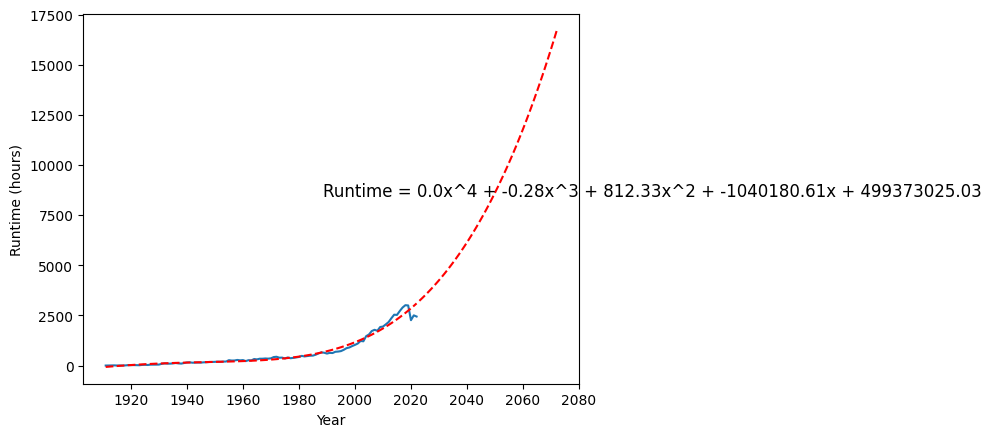

In [24]:


predict_total_lifespan_content(df)

/var/folders/qj/94p7rrz12gd_529xt96yg7n80000gp/T/ipykernel_96735/1748852717.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_group_by_year = df.groupby('year').sum().reset_index()
INFO:root:Hours of existing content: 21930
INFO:root:Hours of future content: 121149
INFO:root:Days of future content: 5047
/var/folders/qj/94p7rrz12gd_529xt96yg7n80000gp/T/ipykernel_96735/1748852717.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_group_by_year = df.groupby('year').sum().reset_index()
INFO:root:Hours of existing content: 19105
INFO:root:Hours of future content: 109437
INFO:root:Days of future content:

For 7.0 cutoff rating, 143080 hours of content with 18250 time left
For 7.1 cutoff rating, 128542 hours of content with 18250 time left
For 7.199999999999999 cutoff rating, 128542 hours of content with 18250 time left
For 7.299999999999999 cutoff rating, 117211 hours of content with 18250 time left
For 7.399999999999999 cutoff rating, 104853 hours of content with 18250 time left
For 7.499999999999998 cutoff rating, 92477 hours of content with 18250 time left
For 7.599999999999998 cutoff rating, 81733 hours of content with 18250 time left
For 7.6999999999999975 cutoff rating, 71118 hours of content with 18250 time left
For 7.799999999999997 cutoff rating, 64584 hours of content with 18250 time left
For 7.899999999999997 cutoff rating, 56071 hours of content with 18250 time left
For 7.9999999999999964 cutoff rating, 49799 hours of content with 18250 time left
For 8.099999999999996 cutoff rating, 41730 hours of content with 18250 time left
For 8.199999999999996 cutoff rating, 36532 hours 

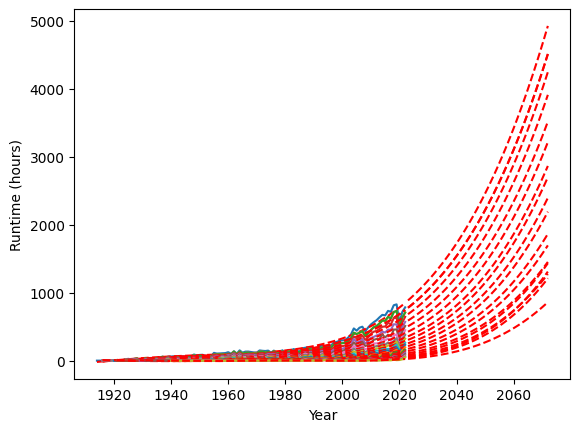

In [15]:
# FIXME - add predicted time already watched
# FIXME - add percentage of content you want to watch

# Find rating cutoff so that lifetime watch hours remaining equals total lifespan content
time_left = lifetime_watch_hours_remaining()

for rating in np.arange(7.0, 9.5, .1):

    df_cutoff = df[df['averageRating'] > rating]
    total_time = predict_total_lifespan_content(df_cutoff)

    print(f"For {rating} cutoff rating, {total_time} hours of content with {time_left} time left")
    if total_time < time_left:
        print(f"Your cutoff rating is {rating}!!")
        break

# TODO - there's definitely a better way to do this
# Calculate the cutoff rating using calculus without a for loop
# https://stackoverflow.com/questions/2828059/solving-linear-equations-involving-logarithms



In [16]:
# Plot stacked chart of int rating distribution per year
# Round averageRating to nearest integer
df['averageRatingInt'] = df['averageRating'].round(0).astype(int)

# Group averageRatingInt by year and sum runtimeHours
df_hours_by_rating = df.groupby(['year', 'averageRatingInt']).sum().reset_index()
# logging.info(df_hours_by_rating)

/var/folders/qj/94p7rrz12gd_529xt96yg7n80000gp/T/ipykernel_96735/3199618867.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_hours_by_rating = df.groupby(['year', 'averageRatingInt']).sum().reset_index()


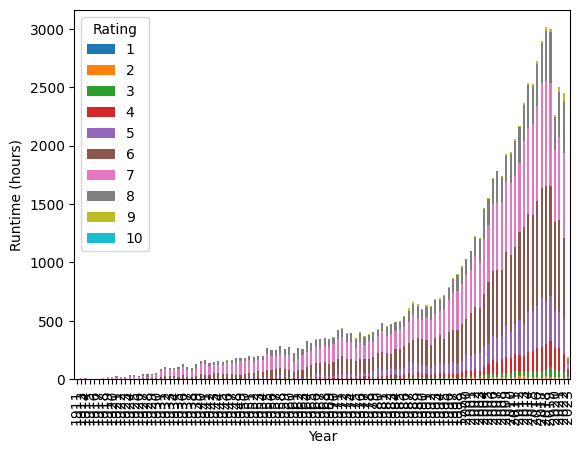

In [17]:
# plt.bar(df_hours_by_rating['year'], df_hours_by_rating[df_hours_by_rating['averageRatingInt']==1]['runtimeHours'])
# df_hours_by_rating[df_hours_by_rating['averageRatingInt']==1]['runtimeHours']
# df_hours_by_rating['year']
df_hours_by_rating['runtimeHours']

df_hours_by_rating = df_hours_by_rating.pivot(index='year', columns='averageRatingInt', values='runtimeHours').fillna(0)
# logging.info(df_hours_by_rating)

# Plot runtimeHours per year
# for x in range(1, 11):
#     plt.plot(df_hours_by_rating.index, df_hours_by_rating[x], label=x)

df_hours_by_rating.plot.bar(stacked=True)

# Stack the bars 1-10 from bottom to top
# Add labels to the plot
plt.xlabel('Year')
plt.ylabel('Runtime (hours)')
plt.legend(title='Rating')
plt.show()

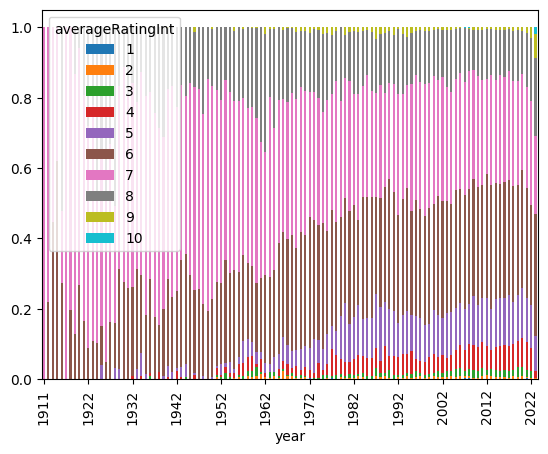

In [20]:
# Is it safe to assume rating-duration distributions stay similar over time?
# NO

df_hours_by_rating['total'] = df_hours_by_rating.sum(axis=1)
df_hours_by_rating = df_hours_by_rating.div(df_hours_by_rating['total'], axis=0)
df_hours_by_rating = df_hours_by_rating.drop(columns=['total'])
# logging.info(df_hours_by_rating)

# Plot as stacked bar chart
# df_hours_by_rating.plot.bar(stacked=True)

# Create a categorical index for the ratings so they are ordered correctly
df_hours_by_rating.index = pd.CategoricalIndex(df_hours_by_rating.index, categories=df_hours_by_rating.index, ordered=True)

# Plot the stacked bar chart
df_hours_by_rating.plot.bar(stacked=True)

plt.xticks(np.arange(0, len(df_hours_by_rating.index), 10))

plt.show()